##Import Dataset

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Importing the Keras libraries and packages
import keras,os
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk.corpus import stopwords
import string

In [13]:
import pandas as pd;

#Loading dataset and rename columns

df = pd.read_csv("/content/drive/MyDrive/Thesis/Dataset/FAQs.csv")
df.columns=["questions","answers"];
df

,questions,answers
0,When was Albert Einstein born?,Albert Einstein was born on 14 March 1879.
1,Where was he born?,"He was born in Ulm, Germany."
2,When did he die?,"He died 18 April 1955 in Princeton, New Jersey..."
3,Who were his parents?,His father was Hermann Einstein and his mother...
4,Did he have any sisters and brothers?,He had one sister named Maja.
5,Did he marry and have children?,He was married to Mileva Marić between 1903 an...
6,Where did he receive his education?,He received his main education at the followin...
7,When was Albert Einstein awarded the Nobel Pri...,"The Nobel Prize Awarding Institution, the Roya..."
8,Did Albert Einstein attend the Nobel Prize Awa...,The Nobel Prize was announced on 9 November 19...
9,For what did he receive the Nobel Prize?,Einstein was rewarded for his many contributio...


##Data Preprocessing

In [14]:
import re
import gensim 
from gensim.parsing.preprocessing import remove_stopwords

#keeping only words in the sentence and removing punctuations.

def clean_sentence(sentence, stopwords=False):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[^a-z0-9\s]', '', sentence)

    
    if stopwords:
         sentence = remove_stopwords(sentence)
    

    
    return sentence
                    
def get_cleaned_sentences(df,stopwords=False):    
    sents=df[["questions"]];
    cleaned_sentences=[]

    for index,row in df.iterrows():
        #print(index,row)
        cleaned=clean_sentence(row["questions"],stopwords);
        cleaned_sentences.append(cleaned);
    return cleaned_sentences;

cleaned_sentences=get_cleaned_sentences(df,stopwords=True)
#print(cleaned_sentences);

print("\n")

cleaned_sentences_with_stopwords=get_cleaned_sentences(df,stopwords=False)
#print(cleaned_sentences_with_stopwords[0]);

In [15]:
df.shape

(10, 2)

In [16]:
df.columns

Index(['questions', 'answers'], dtype='object')

In [17]:
print(df.isnull().sum())

questions    0
answers      0
dtype: int64


In [18]:
print(cleaned_sentences_with_stopwords[0]);

when was albert einstein born


##Word2Vec-Skipgram Model

In [19]:
from gensim.models import Word2Vec 
import gensim.downloader as api

#loading Word2vec google news pretrained model  
v2w_model=None;
try:
    v2w_model = gensim.models.KeyedVectors.load("./w2vecmodel.mod")
    print("Loaded saved W2V model")
except:            
    v2w_model = api.load('word2vec-google-news-300')
    v2w_model.save("./w2vecmodel.mod")
    print("Downloaded and saved glove model")

w2vec_embedding_size=len(v2w_model['computer']);

Downloaded and saved glove model


In [20]:
#creating vectors
def getWordVec(word,model):
        samp=model['computer'];
        vec=[0]*len(samp);
        try:
                vec=model[word];
        except:
                vec=[0]*len(samp);
        return (vec)


def getPhraseEmbedding(phrase,embeddingmodel):
                       
        samp=getWordVec('computer', embeddingmodel);
        vec=numpy.array([0]*len(samp));
        den=0;
        for word in phrase.split():
            #print(word)
            den=den+1;
            vec=vec+numpy.array(getWordVec(word,embeddingmodel));

        return vec.reshape(1, -1)

In [21]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity;
#finding cosine similarity from vectors
def retrieveAndPrintFAQAnswer(question_embedding,sentence_embeddings,FAQdf,sentences):
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sentence_embeddings):
        #sim=cosine_similarity(embedding.reshape(1, -1),question_embedding.reshape(1, -1))[0][0];
        sim=cosine_similarity(faq_embedding,question_embedding)[0][0];
        print(index, sim, sentences[index])
        if sim>max_sim:
            max_sim=sim;
            index_sim=index;
    print("\n")
    print("Question: ",question)
    print("\n");
    print("Retrieved: ",FAQdf.iloc[index_sim,0]) 
    print(FAQdf.iloc[index_sim,1]) 

In [22]:
question_orig="Who was his wife?"
#question_orig=input()
question=clean_sentence(question_orig,stopwords=False);

In [23]:
#With w2Vec
import numpy
sent_embeddings=[];
for sent in cleaned_sentences:
    sent_embeddings.append(getPhraseEmbedding(sent,v2w_model));

question_embedding=getPhraseEmbedding(question,v2w_model);

retrieveAndPrintFAQAnswer(question_embedding,sent_embeddings,df, cleaned_sentences);

0 0.25802384215964247 albert einstein born
1 0.32660566691400267 born
2 0.1614098551897814 die
3 0.3614683752376988 parents
4 0.3834036401370407 sisters brothers
5 0.3912437999536038 marry children
6 0.10785768332422598 receive education
7 0.15500725625985434 albert einstein awarded nobel prize physics
8 0.2631050850224404 albert einstein attend nobel prize award ceremony
9 0.15663458974063318 receive nobel prize


Question:  who was his wife


Retrieved:  Did he marry and have children?
He was married to Mileva Marić between 1903 and 1919. They had three children, Lieserl (born 1902), Hans Albert (born 1904) and Eduard (born 1910). He married Elsa Löwenthal in 1919 and they lived together until her death in 1936.


#Implementing Chatbot using Word2Vec

In [24]:
#embedding the exsiting dataset
sent_embeddings=[];
for sent in cleaned_sentences:
  sent_embeddings.append(getPhraseEmbedding(sent,v2w_model));

In [25]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity;
import numpy
import time

print("Welcome to the Question Answering System")      

while True:
  print("Question:") 
  
  question_orig=input()
  
  if (question_orig.lower()=='quit'):
    break
  measure1 = time.time()
  question=clean_sentence(question_orig,stopwords=False);
  


  question_embedding=getPhraseEmbedding(question,v2w_model);  
  def retrieveAndPrintFAQAnswer(question_embedding,sentence_embeddings,FAQdf,sentences):
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sentence_embeddings):
      sim=cosine_similarity(faq_embedding,question_embedding)[0][0];
      #print(index, sim, sentences[index])
      if sim>max_sim:
        max_sim=sim;
        index_sim=index;
    #print("\n")
    #print("Question: ",question)
    #print("\n");
    #print("Retrieved: ",FAQdf.iloc[index_sim,0]) 
    #print(FAQdf.iloc[index_sim,1]) 
    print("Answer:",FAQdf.iloc[index_sim,1])
    print("----------------------")
    measure2 = time.time()
    print("Response Time",measure2 - measure1)
    print("----------------------")
    print("\n");
    print("Enter Quit to exit: ")
  retrieveAndPrintFAQAnswer(question_embedding,sent_embeddings,df, cleaned_sentences);




print("----------------------")
print("Thank You")
print("----------------------")

Welcome to the Question Answering System
Question:
What was Einstein's father's name?
Answer: His father was Hermann Einstein and his mother was Pauline Einstein (born Koch).
----------------------
Response Time 0.0053060054779052734
----------------------


Enter Quit to exit: 
Question:
At what institutions did he study?
Answer: He received his main education at the following schools: Catholic elementary school in Munich, Germany (1885-1888)Luitpold Gymnasium in Munich, Germany (1888-1894) Cantonal school in Aarau, Switzerland (1895-1896) Swiss Federal Institute of Technology in Zurich, Switzerland (1896-1900) Ph.D. from Zurich University, Switzerland (1905)
----------------------
Response Time 0.004952669143676758
----------------------


Enter Quit to exit: 
Question:
quit
----------------------
Thank You
----------------------


In [42]:
df.columns

Index(['questions', 'answers'], dtype='object')

#**Test Data**

In [52]:
import pandas as pd;

#Load dataset and rename columns

df_test= pd.read_csv("/content/drive/MyDrive/Thesis/Dataset/FAQs_test.csv")
df_test.columns=["questions"];

df_test

,questions
0,What is the date of his death?
1,Did Einstein have siblings?
2,Who was his wife?
3,What was Einstein's father's name?
4,At what institutions did he study?


In [53]:
df_test.columns

Index(['questions'], dtype='object')

In [58]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity;
def retrieveAndPrintFAQAnswer(question_embeddings_test,sentence_embeddings,FAQdf,sentences,FAQdf_test,sentences_test):
  for index_test,faq_embedding_test in enumerate(question_embeddings_test):
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sentence_embeddings):
        
      sim=cosine_similarity(faq_embedding,faq_embedding_test)[0][0];
      #print(index, sim, sentences[index])
      if sim>max_sim:
        max_sim=sim;
        index_sim=index;

    FAQdf_test.iloc[index_test,2]=FAQdf.iloc[index_sim,2]
    FAQdf_test.iloc[index_test,5]=FAQdf.iloc[index_sim,0]
    print("\n")
    print("Question: ",sentences_test[index_test])
    print("\n");
    print("Retrieved: ",FAQdf.iloc[index_sim,0]) 
    print("Answer:",FAQdf.iloc[index_sim,1])    
        

In [41]:
df.columns

Index(['questions', 'answers'], dtype='object')

In [49]:
for i in range(df_test.shape[0]):
 if df_test.iloc[i,0]!=df_test.iloc[i,0]:
   df_test.iloc[i,0]='InCorrect'
 else:
   df_test.iloc[i,0]='correct'
df_test

,questions
0,correct
1,correct
2,correct
3,correct
4,correct


In [59]:
print(cleaned_sentences_with_stopwords[0]);

when was albert einstein born


In [63]:
list_data_answers=df.questions.values.tolist()
list_data_FoundCode=df.answers.tolist()

In [64]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
multilabel_confusion_matrix(list_data_answers, list_data_FoundCode)

array([[[9., 1.],
        [0., 0.]],

       [[9., 0.],
        [1., 0.]],

       [[9., 0.],
        [1., 0.]],

       [[9., 0.],
        [1., 0.]],

       [[9., 1.],
        [0., 0.]],

       [[9., 0.],
        [1., 0.]],

       [[9., 1.],
        [0., 0.]],

       [[9., 1.],
        [0., 0.]],

       [[9., 1.],
        [0., 0.]],

       [[9., 1.],
        [0., 0.]],

       [[9., 1.],
        [0., 0.]],

       [[9., 1.],
        [0., 0.]],

       [[9., 1.],
        [0., 0.]],

       [[9., 1.],
        [0., 0.]],

       [[9., 0.],
        [1., 0.]],

       [[9., 0.],
        [1., 0.]],

       [[9., 0.],
        [1., 0.]],

       [[9., 0.],
        [1., 0.]],

       [[9., 0.],
        [1., 0.]],

       [[9., 0.],
        [1., 0.]]])

In [65]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix


cm = confusion_matrix(list_data_answers, list_data_FoundCode, binary=False)

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


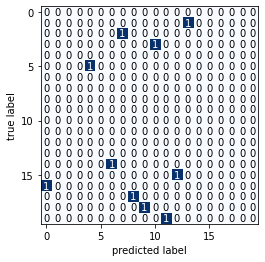

In [66]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import pprint
#creating confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [67]:
print(metrics.classification_report(list_data_answers, list_data_FoundCode))

                                                                                                                                                                                                                                                                                                                                                 precision    recall  f1-score   support

                                                                                                                                                                                                                                                                                                     Albert Einstein was born on 14 March 1879.       0.00      0.00      0.00       0.0
                                                                                                                                                                                                                                                     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1